# Imports

In [1]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install albumentations

  Using cached albumentations-1.4.3-py3-none-any.whl.metadata (37 kB)
Using cached albumentations-1.4.3-py3-none-any.whl (137 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import cv2
import shutil
import os
import zipfile
import gzip
import random
from pprint import pprint

from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt
import random

## Unzipping the dataset

### DONT USE UNTIL PORTING A NEW DATASET

In [ ]:
directory_to_remove = 'data_cloud_final/data_cloud_final/imgs/train_set'

try:
    shutil.rmtree(directory_to_remove)
    print(f"Directory '{directory_to_remove}' successfully removed.")
except OSError as e:
    print(f"Error: {directory_to_remove} : {e.strerror}")

In [ ]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Change the working directory to the parent directory
os.chdir('..')

# Verify the change
new_directory = os.getcwd()
print("New working directory:", new_directory)

In [33]:
# Path to your ZIP file
zip_file = "data_cloud_final.zip"
destination_folder = "data_cloud_final"

try:
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

        # Unzip the contents of the gzip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        print("Files unzipped successfully.")
    else:
        print("Destination folder already exists. Skipping extraction.")
except Exception as e:
    print(f"Error: {e}")

Files unzipped successfully.


# Original Data check

In [22]:
imgs = r'data_cloud_final/data_cloud_final/imgs/train'

In [23]:
# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(imgs) if f.is_dir()]
print(subfolders)

['data_cloud_final/data_cloud_final/imgs/train/YES', 'data_cloud_final/data_cloud_final/imgs/train/NO', 'data_cloud_final/data_cloud_final/imgs/train/.ipynb_checkpoints']


In [24]:
yes_subfolder = subfolders[0]
yes_subfolder

'data_cloud_final/data_cloud_final/imgs/train/YES'

In [25]:
yes_subfolder_subfolder = [f.path for f in os.scandir(yes_subfolder) if f.is_dir()]
yes_subfolder_subfolder

['data_cloud_final/data_cloud_final/imgs/train/YES/c3',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c1',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c6',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c7',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c4',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c5',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c2',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c8',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c9']

In [26]:
no_subfolder=subfolders[1]
no_subfolder

'data_cloud_final/data_cloud_final/imgs/train/NO'

In [27]:
no_subfolder_subfolder = [f.path for f in os.scandir(no_subfolder) if f.is_dir()]
no_subfolder_subfolder

['data_cloud_final/data_cloud_final/imgs/train/NO/c0']

In [28]:
images_yes = []

for subfolder in yes_subfolder_subfolder:
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.jpg')]
    images_yes.extend(files)

In [29]:
len(images_yes)

2259

In [30]:
image_no=[]

for subfolder in no_subfolder_subfolder:
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.jpg')]
    image_no.extend(files)

In [31]:
len(image_no)

2259

# Training set creation {Balanced}

In [32]:
def count_jpg_files_in_directory(path):
    # Initialize a counter
    jpg_count = 0

    # Walk through the directory and count JPG files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_count += 1

    return jpg_count

In [33]:
# Number of images to pick from each subfolder
num_images_to_train_test = 900

### NO

In [34]:
# Pick the specified number of images
selected_images_train = random.sample(image_no, num_images_to_train_test)

# make destination directory
destination_dir_train = r'training_set/'

# Remove existing directories and create new ones
shutil.rmtree(destination_dir_train, ignore_errors=True)
os.makedirs(destination_dir_train)

for image_path in selected_images_train:
    # Create the destination subfolder structure in the destination directory
    relative_path = os.path.relpath(image_path, imgs)
    relative_path = relative_path.replace("/c0","")
    destination_path = os.path.join(destination_dir_train, relative_path)
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    # Copy the image
    shutil.copyfile(image_path, destination_path)

print(f"{num_images_to_train_test} images from each subfolder have been copied to {destination_dir_train}.")

900 images from each subfolder have been copied to training_set/.


In [35]:
path = r'training_set/NO'
file_count = count_jpg_files_in_directory(path)
print("Number of NO images in directory:", file_count)

Number of NO images in directory: 900


### YES

In [36]:
for folder in yes_subfolder_subfolder:

    images = [f.path for f in os.scandir(folder) if f.is_file() and f.name.endswith(('.jpg'))]
    # print(images[:3])
    # Pick the specified number of images
    selected_images_train = random.sample(images, int(num_images_to_train_test / 9))

    # make destination directory
    destination_dir_train = r'training_set/'

    os.makedirs(destination_dir_train,exist_ok=True)

    for image_path in selected_images_train:
        # Create the destination subfolder structure in the destination directory
        relative_path = os.path.relpath(image_path, imgs)

         # Define the list of 'cX' values to replace
        c_values_to_replace = [f'/c{i}' for i in range(10)]

        # Remove 'cX' values from the relative_path
        for c_value in c_values_to_replace:
            relative_path = relative_path.replace(c_value, '')

        destination_path = os.path.join(destination_dir_train, relative_path)
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        # Copy the image
        shutil.copyfile(image_path, destination_path)

    print(f"{int(num_images_to_train_test / 9)} images from  {folder} have been copied to {destination_dir_train}.")

100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c3 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c1 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c6 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c7 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c4 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c5 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c2 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c8 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c9 have been copied to training_set/.


In [38]:
path = r'training_set/YES'
file_count = count_jpg_files_in_directory(path)
print("Number of YES images in directory:", file_count)

Number of YES images in directory: 900


# Loading Images

In [4]:
# Define the directory path
directory = 'training_set/'

# Function to recursively find image files in subfolders
def find_images(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file has an image extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_files.append(os.path.join(root, file))
    return image_files

# Find all image files in subfolders
all_image_paths = find_images(directory)

In [5]:
all_image_paths_sorted = sorted(all_image_paths)

In [6]:
len(all_image_paths_sorted)

1800

# Import CUDA

In [7]:
# Check if GPU is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # Print information about each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available. PyTorch is using CPU.")

Number of available GPUs: 1
GPU 0: Tesla T4


# Train / Test {Creation}

In [15]:
train_x = all_image_paths_sorted
train_y = [path.split('/')[-2] for path in all_image_paths_sorted]

In [16]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=5, stratify=train_y)

## Trainsform 

In [55]:
transforms = A.Compose(
    [
        A.Resize(height=300, width=300), # Resize to 300x300"
        A.ToFloat(),
        ToTensorV2(),
    ]
)

In [18]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
encoded_labels_train = label_encoder.fit_transform(train_y)
tensor_encoded_labels_train = torch.tensor(encoded_labels_train)
pprint(tensor_encoded_labels_train)


# Fit label encoder and transform labels
encoded_labels_test = label_encoder.fit_transform(test_y)
tensor_encoded_labels_test = torch.tensor(encoded_labels_test)
pprint(tensor_encoded_labels_test)

tensor([0, 0, 1,  ..., 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       

# Image Dataset Class

In [23]:
class image_Dataset(Dataset):
    def __init__(self, image_paths, tensor_encoded_labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to images.
            labels (list): List of labels corresponding to the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths = image_paths
        self.labels = tensor_encoded_labels
        self.transform = transform


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None and callable(self.transform):
            image = self.transform(image=image)["image"]

        # Convert label to PyTorch tensor
        label = self.labels[idx]

        return image, label

## Dataset check

In [20]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = image_Dataset(train_x,tensor_encoded_labels_train,transforms)
test_dataset = image_Dataset(test_x,tensor_encoded_labels_test,transforms)

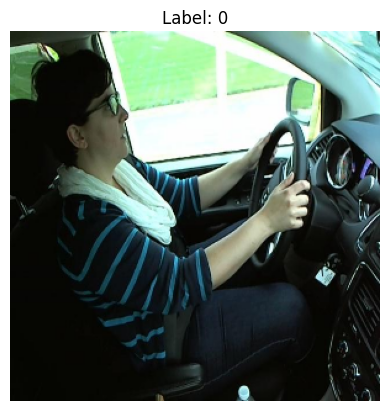

The shape of tensor for 50th image in train dataset:  torch.Size([3, 300, 300])
The label for 50th image in train dataset:  tensor(0)


In [21]:
for i in range(1):
  image, label = train_dataset[i]
  image = TF.to_pil_image(image)  # Convert the tensor to a PIL Image
  image = np.array(image)
  plt.imshow(image)
  plt.title(f"Label: {label}")
  plt.axis('off')  # Turn off axis
  plt.show()

print('The shape of tensor for 50th image in train dataset: ',train_dataset[0][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[0][1])

In [22]:
#######################################################
#                  load Dataset
#######################################################

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Different Model Architectures

## Architecture-1

In [56]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageClassifier, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3))
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*33*33, out_features=num_classes))

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x

### Version 1

#### V1.0

In [52]:
modelV1_0 = ImageClassifier()
modelV1_0.cuda()
modelV1_0.train()

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=139392, out_features=2, bias=True)
  )
)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1_0.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20

In [54]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1_0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 7.9078
Epoch [2/20], Loss: 1.0761
Epoch [3/20], Loss: 1.7510
Epoch [4/20], Loss: 0.5155
Epoch [5/20], Loss: 0.0493
Epoch [6/20], Loss: 0.0195
Epoch [7/20], Loss: 0.0011
Epoch [8/20], Loss: 0.0006
Epoch [9/20], Loss: 0.0001
Epoch [10/20], Loss: 0.0000
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0000
Epoch [15/20], Loss: 0.0000
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


In [55]:
torch.save(modelV1_0, 'modelV1_0.pth')

#### V1.1

In [56]:
modelV1_1 = ImageClassifier()
modelV1_1 = modelV1_1.to('cuda')
modelV1_1.train()

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=139392, out_features=2, bias=True)
  )
)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1_1.parameters(), lr=0.0001, momentum=0.50)
num_epochs = 20

In [58]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 1.2609
Epoch [2/20], Loss: 0.3261
Epoch [3/20], Loss: 0.1339
Epoch [4/20], Loss: 0.1013
Epoch [5/20], Loss: 0.0552
Epoch [6/20], Loss: 0.0393
Epoch [7/20], Loss: 0.0317
Epoch [8/20], Loss: 0.0271
Epoch [9/20], Loss: 0.0238
Epoch [10/20], Loss: 0.0213
Epoch [11/20], Loss: 0.0192
Epoch [12/20], Loss: 0.0176
Epoch [13/20], Loss: 0.0163
Epoch [14/20], Loss: 0.0152
Epoch [15/20], Loss: 0.0142
Epoch [16/20], Loss: 0.0134
Epoch [17/20], Loss: 0.0127
Epoch [18/20], Loss: 0.0121
Epoch [19/20], Loss: 0.0115
Epoch [20/20], Loss: 0.0110


In [59]:
torch.save(modelV1_1, 'modelV1_1.pth')

#### V1.2

In [60]:
modelV1_2 = ImageClassifier()
modelV1_2 = modelV1_2.to('cuda')
modelV1_2.train()

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=139392, out_features=2, bias=True)
  )
)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV1_2.parameters(), lr=0.0001)
num_epochs = 20

In [62]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 2.0248
Epoch [2/20], Loss: 0.2243
Epoch [3/20], Loss: 0.0764
Epoch [4/20], Loss: 0.0348
Epoch [5/20], Loss: 0.0184
Epoch [6/20], Loss: 0.0088
Epoch [7/20], Loss: 0.0052
Epoch [8/20], Loss: 0.0038
Epoch [9/20], Loss: 0.0028
Epoch [10/20], Loss: 0.0021
Epoch [11/20], Loss: 0.0019
Epoch [12/20], Loss: 0.0018
Epoch [13/20], Loss: 0.0016
Epoch [14/20], Loss: 0.0015
Epoch [15/20], Loss: 0.0014
Epoch [16/20], Loss: 0.0013
Epoch [17/20], Loss: 0.0013
Epoch [18/20], Loss: 0.0012
Epoch [19/20], Loss: 0.0011
Epoch [20/20], Loss: 0.0011


In [63]:
torch.save(modelV1_2, 'modelV1_2.pth')

## Architecture-2

In [28]:
class ImageClassifier_V2(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageClassifier_V2, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),  # Adjusted kernel_size
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=3, stride=1))  # Adjusted kernel_size and stride

        # Calculate the input size for the linear layer based on the output of conv_layer_3
        self.classifier_input_size = 512*34*34  # Adjusted based on the spatial dimensions

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.classifier_input_size, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        #print("Shape after conv_layer_1:", x.shape)

        x = self.conv_layer_2(x)

        #print("Shape after conv_layer_2:", x.shape)
        x = self.conv_layer_3(x)

        #print("Shape after conv_layer_3:", x.shape)


        x = self.classifier(x)
        return x

### Version 2

#### V2.0

In [24]:
torch.cuda.empty_cache()

In [67]:
torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  73814 KiB |   4910 MiB |  18868 GiB |  18868 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  73814 KiB |   4910 MiB |  18868 GiB |  18868 GiB |\n|---------------------------------------------------------------------------|\n| Requested memory      |  71958 KiB |   4909 MiB |  18866 GiB |  18866 GiB |\n|--------------------------------------------------

In [68]:
modelV2_0 = ImageClassifier_V2()
modelV2_0 = modelV2_0.to('cuda')
modelV2_0.train()

ImageClassifier_V2(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV2_0.parameters(), lr=0.005, momentum=0.03)
num_epochs = 20

In [70]:
# Assuming you have a DataLoader named 'train_loader'
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV2_0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 548.7681
Epoch [2/20], Loss: 200.1508
Epoch [3/20], Loss: 76.6271
Epoch [4/20], Loss: 48.4247
Epoch [5/20], Loss: 29.3480
Epoch [6/20], Loss: 19.6634
Epoch [7/20], Loss: 24.5027
Epoch [8/20], Loss: 11.8800
Epoch [9/20], Loss: 5.0428
Epoch [10/20], Loss: 5.9622
Epoch [11/20], Loss: 4.4721
Epoch [12/20], Loss: 2.5547
Epoch [13/20], Loss: 2.5249
Epoch [14/20], Loss: 23.8425
Epoch [15/20], Loss: 2.8775
Epoch [16/20], Loss: 2.0994
Epoch [17/20], Loss: 1.4300
Epoch [18/20], Loss: 1.2479
Epoch [19/20], Loss: 0.7647
Epoch [20/20], Loss: 0.4781


In [75]:
torch.save(modelV2_0, 'modelV2_0.pth')

#### V2.1

In [71]:
modelV2_1 = ImageClassifier_V2()
modelV2_1 = modelV2_1.to('cuda')
modelV2_1.train()

ImageClassifier_V2(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV2_1.parameters(), lr=0.0001)
num_epochs = 20

In [73]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels  = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV2_1(inputs)
        loss1 = criterion(outputs, labels)
        loss1.backward()
        optimizer.step()
        total_loss += (loss1.item())*inputs.size(0)


    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 8.3365
Epoch [2/20], Loss: 1.3942
Epoch [3/20], Loss: 0.2351
Epoch [4/20], Loss: 0.0691
Epoch [5/20], Loss: 0.1152
Epoch [6/20], Loss: 0.1939
Epoch [7/20], Loss: 0.0586
Epoch [8/20], Loss: 0.0235
Epoch [9/20], Loss: 0.0033
Epoch [10/20], Loss: 0.0131
Epoch [11/20], Loss: 0.0194
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0021
Epoch [14/20], Loss: 0.0005
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


In [74]:
torch.save(modelV2_1, 'modelV2_1.pth')

#### V2.2

In [ ]:
modelV2_2 = ImageClassifier_V2()
modelV2_2 = modelV2_2.to('cuda')
modelV2_2.train()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelV2_2.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels  = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV2_2(inputs)
        loss1 = criterion(outputs, labels)
        loss1.backward()
        optimizer.step()
        total_loss += (loss1.item())*inputs.size(0)


    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [ ]:
torch.save(modelV2_2, 'modelV2_2.pth')

# Basic Evaluation

In [83]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
            accuracy = float(num_correct) / float(num_samples) * 100

    return accuracy , num_correct , num_samples

# Architecture - 1

### modelV1_0

In [45]:
modelV1_0 = torch.load("modelV1_0.pth").to('cuda')

In [29]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 97.22%, Correct: 350, Total: 360


### modelV1_1

In [ ]:
modelV1_1 = torch.load("modelV1_1.pth").to('cuda')

In [30]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 98.06%, Correct: 353, Total: 360


### modelV1_2

In [ ]:
modelV1_2 = torch.load("modelV1_2.pth").to('cuda')

In [31]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_2)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_2)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 98.33%, Correct: 354, Total: 360


# Architecture - 2

### modelV2_0

In [32]:
modelV2_0 = torch.load("modelV2_0.pth").to('cuda')
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2_0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2_0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 98.75%, Correct: 1422, Total: 1440
Test Set Accuracy: 91.67%, Correct: 330, Total: 360


### modelV2_1

In [33]:
modelV2_1 = torch.load("modelV2_1.pth").to('cuda')
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2_1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2_1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 99.17%, Correct: 357, Total: 360


# CROSS VALIDATION TEST

In [69]:
def train_test(model, device, train_loader, test_loader,optimizer,criterion, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels  = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += (loss.item())*inputs.size(0)


        average_loss = total_loss / len(train_loader.sampler)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')
        
    model.eval()
        
    train_accuracy, train_correct, train_total = check_accuracy(train_loader, model)
    test_accuracy, test_correct, test_total = check_accuracy(test_loader, model)

    print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
    print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")    
    
    return train_accuracy, test_accuracy

### validation / test / train split for Kfold

In [25]:
yes_image_paths = [path for path in all_image_paths_sorted if 'YES' in path]
no_image_paths = [path for path in all_image_paths_sorted if 'NO' in path]

# Randomly select 50 YES and 50 NO image paths
selected_yes_image_paths = random.sample(yes_image_paths, 50)
selected_no_image_paths = random.sample(no_image_paths, 50)

# Create validation set containing selected image paths
validation_set = selected_yes_image_paths + selected_no_image_paths

In [26]:
validation_X = validation_set

In [27]:
validation_Y = [path.split('/')[-2] for path in validation_X]

In [28]:
label_encoder = LabelEncoder()
encoded_labels_validation_dataset = label_encoder.fit_transform(validation_Y)
tensor_encoded_labels_validation_dataset = torch.tensor(encoded_labels_validation_dataset)
pprint(tensor_encoded_labels_validation_dataset)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


In [88]:
validation_dataset = image_Dataset(validation_X,tensor_encoded_labels_validation_dataset,transforms)

In [89]:
validation_dataset[0]

(tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.9373, 0.8745, 0.6627],
          [0.0588, 0.0588, 0.0588,  ..., 0.9569, 0.9843, 0.9804],
          [0.0627, 0.0627, 0.0627,  ..., 0.9216, 0.9373, 0.9529],
          ...,
          [0.0510, 0.0510, 0.0471,  ..., 0.0392, 0.0353, 0.0314],
          [0.0471, 0.0431, 0.0392,  ..., 0.0392, 0.0353, 0.0314],
          [0.0431, 0.0392, 0.0353,  ..., 0.0392, 0.0353, 0.0314]],
 
         [[0.0627, 0.0627, 0.0627,  ..., 0.9725, 0.8863, 0.6588],
          [0.0627, 0.0627, 0.0627,  ..., 1.0000, 0.9961, 0.9843],
          [0.0667, 0.0667, 0.0667,  ..., 1.0000, 0.9961, 1.0000],
          ...,
          [0.0588, 0.0588, 0.0549,  ..., 0.0314, 0.0275, 0.0235],
          [0.0549, 0.0510, 0.0471,  ..., 0.0314, 0.0275, 0.0235],
          [0.0510, 0.0471, 0.0431,  ..., 0.0314, 0.0275, 0.0235]],
 
         [[0.0431, 0.0431, 0.0431,  ..., 0.8902, 0.8118, 0.5922],
          [0.0431, 0.0431, 0.0431,  ..., 0.9137, 0.9333, 0.9176],
          [0.0471, 0.0471, 0.0471,  ...,

In [78]:
train_set = [path for path in all_image_paths_sorted if path not in validation_set]

In [33]:
X = train_set
Y = [path.split('/')[-2] for path in train_set]

In [34]:
dataset = list(zip(X, Y))

In [35]:
dataset[0]

('training_set/NO/img_16990.jpg', 'NO')

In [36]:
encoded_labels_Kfold_dataset = label_encoder.fit_transform(Y)
tensor_encoded_labels_Kfold_dataset = torch.tensor(encoded_labels_Kfold_dataset)
pprint(tensor_encoded_labels_Kfold_dataset)

tensor([0, 0, 0,  ..., 1, 1, 1])


In [60]:
#######################################################
#                  Create Dataset
#######################################################

cross_dataset = image_Dataset(X,tensor_encoded_labels_Kfold_dataset,transforms)

In [91]:
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64)

In [39]:
# Define the number of folds and batch size
k_folds = 10
batch_size = 64

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

### Cross validation of V1.0

In [71]:
train_accuracies_V1_0 = []
test_accuracies_V1_0 = []

In [72]:
for fold, (train_idx, test_idx) in enumerate(kf.split(cross_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    
    epoch  = 20
    
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=128,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=128,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

    # Train the model on the current fold
    train_accuracy,test_accuracy = train_test(model, device, train_loader,test_loader, optimizer,criterion, epoch)
        
    # Append accuracies to lists
    train_accuracies_V1_0.append(train_accuracy)
    test_accuracies_V1_0.append(test_accuracy)

Fold 1
-------
Epoch [1/20], Loss: 12.4184
Epoch [2/20], Loss: 1.3795
Epoch [3/20], Loss: 0.2342
Epoch [4/20], Loss: 0.0869
Epoch [5/20], Loss: 0.0562
Epoch [6/20], Loss: 0.0169
Epoch [7/20], Loss: 0.0173
Epoch [8/20], Loss: 0.0040
Epoch [9/20], Loss: 0.0011
Epoch [10/20], Loss: 0.0006
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0002
Train Set Accuracy: 100.00%, Correct: 1530, Total: 1530
Test Set Accuracy: 97.65%, Correct: 166, Total: 170
Fold 2
-------
Epoch [1/20], Loss: 19.2928
Epoch [2/20], Loss: 1.9742
Epoch [3/20], Loss: 0.4999
Epoch [4/20], Loss: 0.2158
Epoch [5/20], Loss: 0.1003
Epoch [6/20], Loss: 0.0499
Epoch [7/20], Loss: 0.0414
Epoch [8/20], Loss: 0.0185
Epoch [9/20], Loss: 0.0100
Epoch [10/20], Loss: 0.0085
Epoch [11/20], Loss: 0.0021
Epoch [12/

In [73]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies_V1_0)
avg_test_accuracy = np.mean(test_accuracies_V1_0)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

Average Train Set Accuracy: 100.00%
Average Test Set Accuracy: 97.29%


#### Check on validation set

In [92]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")

Validation Set Accuracy: 96.00%, Correct: 96, Total: 100


# Save all in google bucket

In [79]:
!gsutil cp * gs://igneous-core-416413-eu-notebooks

Copying file://Completed_Jai_Audio&Speech_comp47700_PL1.ipynb [Content-Type=application/octet-stream]...
Copying file://Copy_of_fyp.ipynb [Content-Type=application/octet-stream]...     
Copying file://FYP_CROSS.ipynb [Content-Type=application/octet-stream]...       
Copying file://README.md [Content-Type=text/markdown]...                        
Omitting directory "file://data_cloud_final". (Did you mean to do cp -r?)       

==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://data_cloud_final.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
con